# Holt Winters Exponential Smoothing
Exponential smoothing methods produce forecasts with weighted averages of past observations, with the weights decaying exponentially as the observations get older. Holt-Winters Exponential Smoothing is a smoothing approach that further accounts for a trend and a seasonal component in the data.

For comparison Holt Winters Exponential Smoothing (HWES) will be applied on the non-transformed `total_cases` as well as on the log-transformed data `logged_cases`. Then the predictions on the train_train and the train_test dataset will be forecasted and plotted. To prevent that the forecasts are below zero (negative numbers of dengue are not possible), the predictions will be exposed to the `clip(lower=0)`-function, which replaces negative predictions with zero. 

## Setup

In [34]:
# Loading packages and their components
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing #, Holt, SimpleExpSmoothing

from own_functions import model_classification 
from own_functions import log_cases

import warnings
warnings.filterwarnings('ignore')

In [35]:
# set dictionary to access colors for plotting
colors= {'actual_weekly':'#a2bffe',
         'actual_monthly':'#26538d',
         'predicted_weekly':'coral',
         'predicted_monthly':'sienna'}

In [16]:
# load data (as only the total_cases are used, no feature engineering is nesessary)
data_subsets_splitted_joined = pickle.load(open('splitted_joined_data.pickle', 'rb'))

# splitting the data into their parts
sj_train_train, \
sj_train_test, \
sj_test, \
iq_train_train, \
iq_train_test, \
iq_test = data_subsets_splitted_joined

In [17]:
# get log of cases as column
sj_train_train = log_cases(sj_train_train)
sj_train_test = log_cases(sj_train_test)
iq_train_train = log_cases(iq_train_train)
iq_train_test = log_cases(iq_train_test)

## San Juan

In [18]:
# HWES on non-transformed cases
sj_expo = ExponentialSmoothing(sj_train_train.total_cases, 
                               trend=None, 
                               seasonal='add', 
                               seasonal_periods=52)
sj_expo_fit = sj_expo.fit() 

# in-sample prediction on train_train data
sj_pred_train = sj_expo_fit.predict(0, len(sj_train_train)).clip(lower=0)

# forecasting train_test data
sj_pred_test = sj_expo_fit.forecast(steps=len(sj_train_test.total_cases)).clip(lower=0)

In [19]:
# HWES with log-transformed cases
sj_expo_log = ExponentialSmoothing(sj_train_train.logged_cases, 
                               trend=None, 
                               seasonal='add', 
                               seasonal_periods=52)
sj_expo_fit_log = sj_expo_log.fit() 

# in-sample prediction on train_train data (clip-function to replace negative predictions with zero)
sj_pred_train_log = sj_expo_fit_log.predict(0, len(sj_train_train))

# forecasting train_test data (clip-function to replace negative predictions with zero)
sj_pred_test_log = sj_expo_fit_log.forecast(steps=len(sj_train_test.logged_cases))

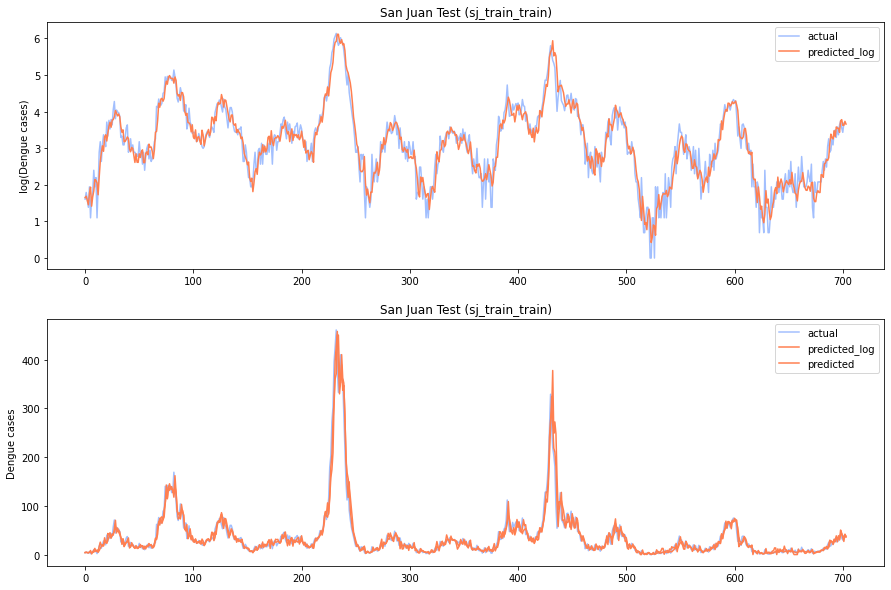

In [20]:
# plot predicted log cases for SJ train_tain
fig, ax = plt.subplots(2, 1, figsize=(15,10))

# first plot on the predictions on the log-scale
sj_train_train.reset_index().logged_cases.plot(ax=ax[0], color=colors['actual_weekly'])
sj_pred_train_log.reset_index(drop=True).plot(ax=ax[0], color=colors['predicted_weekly']);
ax[0].legend(labels=['actual', 'predicted_log'])
ax[0].set(title='San Juan Test (sj_train_train)', ylabel='log(Dengue cases)');

# second plot on the total-cases scale
sj_train_train.reset_index().total_cases.plot(ax=ax[1], color=colors['actual_weekly'])
(np.exp(sj_pred_train_log)-1).reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_weekly']);
sj_pred_train.reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_weekly']);
ax[1].legend(labels=['actual', 'predicted_log', 'predicted'])
ax[1].set(title='San Juan Test (sj_train_train)', ylabel='Dengue cases');

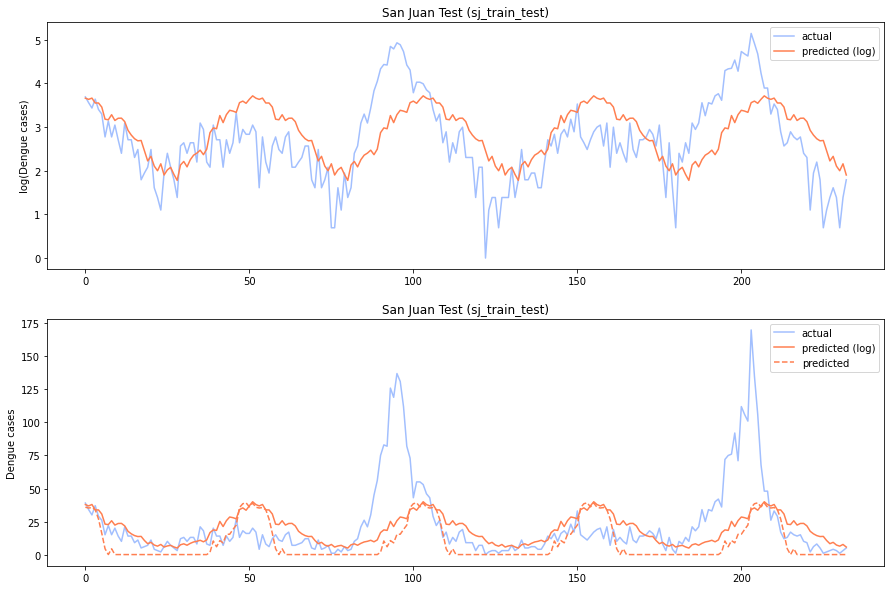

In [21]:
# plot predicted log cases for SJ train_test
fig, ax = plt.subplots(2, 1, figsize=(15,10))

# first plot on the log-scale
sj_train_test.reset_index().logged_cases.plot(ax=ax[0], color=colors['actual_weekly'])
sj_pred_test_log.reset_index(drop=True).plot(ax=ax[0], color=colors['predicted_weekly']);
ax[0].legend(labels=['actual', 'predicted (log)'])
ax[0].set(title='San Juan Test (sj_train_test)', ylabel='log(Dengue cases)');

# second plot on the total-cases scale
sj_train_test.reset_index().total_cases.plot(ax=ax[1], color=colors['actual_weekly'])
(np.exp(sj_pred_test_log)-1).reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_weekly']);
sj_pred_test.reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_weekly'], ls='--');
ax[1].legend(labels=['actual', 'predicted (log)', 'predicted'])
ax[1].set(title='San Juan Test (sj_train_test)', ylabel='Dengue cases');

### Evaluation

In [22]:
# evaluation for predictions from the HWES on non-transformed 
model_classification(sj_train_test.total_cases, sj_pred_test)

--------------------
RMSE: 29.68
--------------------
MAE: 17.77
Explained variance: 0.141
--------------------


In [23]:
# evaluation for predictions from the HWES on log-transformed 
model_classification(sj_train_test.total_cases, np.exp(sj_pred_test_log)-1)

--------------------
RMSE: 26.65
--------------------
MAE: 15.42
Explained variance: 0.145
--------------------


We can already see in the plots that the HWES on the log-transformed cases predicts the actual cases more precisely than the HWES on the non-transformed cases. This model (HWES on the non-transformed total cases) would predict negative values at certain times, which cannot happen after the log-transformation (due to the transformation). Furthermore, the RMSE and the MAE of the HWES on the log-transformed total cases is lower than from the HWES on non-transformed cases.

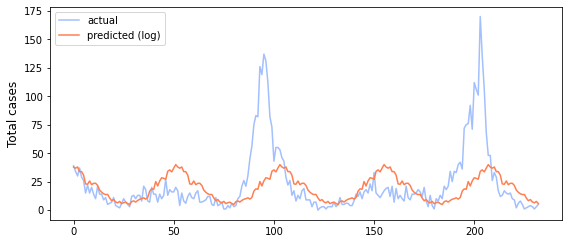

In [24]:
# Plot for saving with only the predictions from the HWES on log-transformed data
fig, ax = plt.subplots(figsize=(8,3.5))

# setup the figure with actual and predicted values
sj_train_test.reset_index().total_cases.plot(ax=ax, color=colors['actual_weekly'])
(np.exp(sj_pred_test_log)-1).reset_index(drop=True).plot(ax=ax, color=colors['predicted_weekly']);
ax.legend(labels=['actual', 'predicted (log)'], loc=0)
ax.set_ylabel('Total cases', fontsize=12)
ax.set_xlabel('')
ax.tick_params(labelsize=10)

fig.tight_layout()  
fig.savefig('plots/SJ_holt_winters.png', dpi=200)

## Iquitos

In [25]:
# HWES on non-transformed cases
iq_expo = ExponentialSmoothing(iq_train_train.total_cases, 
                               trend=None, 
                               seasonal='add', 
                               seasonal_periods=52)
iq_expo_fit = iq_expo.fit() 

# in-sample prediction on train data
iq_pred_train = iq_expo_fit.predict(0, len(iq_train_train)).clip(lower=0)

# forecasting test data
iq_pred_test = iq_expo_fit.forecast(steps=len(iq_train_test.total_cases)).clip(lower=0)

In [26]:
# HWES on log-transformed cases
iq_expo_log = ExponentialSmoothing(iq_train_train.logged_cases, 
                               trend=None, 
                               seasonal='add', 
                               seasonal_periods=52)
iq_expo_fit_log = iq_expo_log.fit() 

# in-sample prediction on train data
iq_pred_train_log = iq_expo_fit_log.predict(0, len(iq_train_train))

# forecasting test data
iq_pred_test_log = iq_expo_fit_log.forecast(steps=len(iq_train_test.logged_cases))

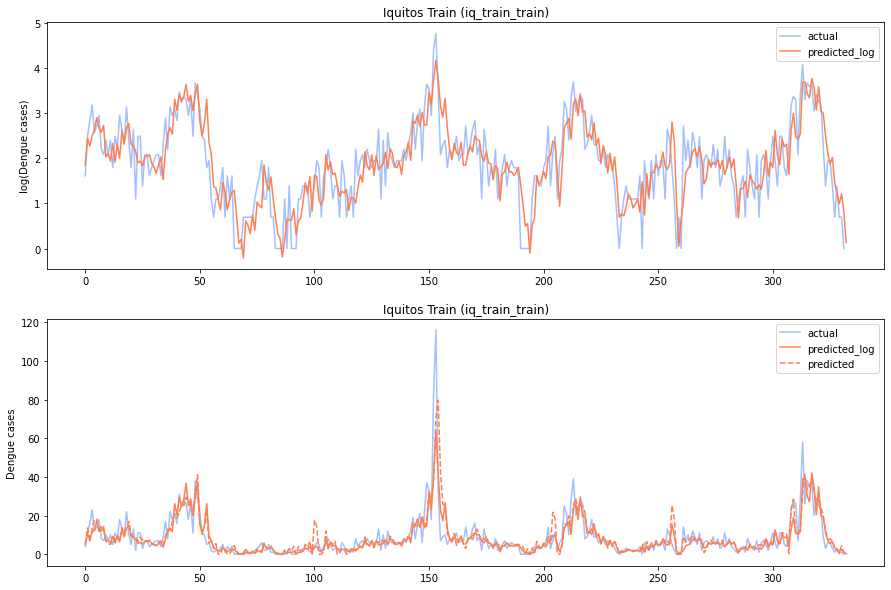

In [27]:
# plot predicted log cases for iq train_tain
fig, ax = plt.subplots(2, 1, figsize=(15,10))

# first plot on the predictions on the log-scale
iq_train_train.reset_index().logged_cases.plot(ax=ax[0], color=colors['actual_weekly'])
iq_pred_train_log.reset_index(drop=True).plot(ax=ax[0], color=colors['predicted_weekly']);
ax[0].legend(labels=['actual', 'predicted_log'])
ax[0].set(title='Iquitos Train (iq_train_train)', ylabel='log(Dengue cases)');

# second plot on the total-cases scale
iq_train_train.reset_index().total_cases.plot(ax=ax[1], color=colors['actual_weekly'])
(np.exp(iq_pred_train_log)-1).reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_weekly']);
iq_pred_train.reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_weekly'], ls='--');
ax[1].legend(labels=['actual', 'predicted_log', 'predicted'])
ax[1].set(title='Iquitos Train (iq_train_train)', ylabel='Dengue cases');

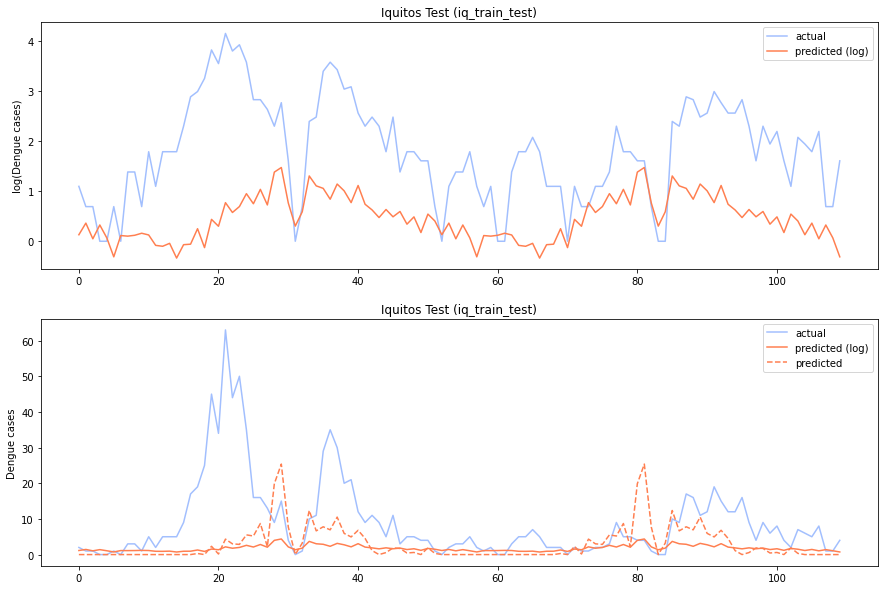

In [28]:
# plot predicted log cases for iq train_test
fig, ax = plt.subplots(2, 1, figsize=(15,10))

# first plot on the predictions on the log-scale
iq_train_test.reset_index().logged_cases.plot(ax=ax[0], color=colors['actual_weekly'])
iq_pred_test_log.reset_index(drop=True).plot(ax=ax[0], color=colors['predicted_weekly']);
ax[0].legend(labels=['actual', 'predicted (log)'])
ax[0].set(title='Iquitos Test (iq_train_test)', ylabel='log(Dengue cases)');

# second plot on the total-cases scale
iq_train_test.reset_index().total_cases.plot(ax=ax[1], color=colors['actual_weekly'])
np.exp(iq_pred_test_log.reset_index(drop=True)).plot(ax=ax[1], color=colors['predicted_weekly']);
iq_pred_test.reset_index(drop=True).plot(ax=ax[1], color=colors['predicted_weekly'], ls='--');
ax[1].legend(labels=['actual', 'predicted (log)', 'predicted'])
ax[1].set(title='Iquitos Test (iq_train_test)', ylabel='Dengue cases');

### Evaluation

In [29]:
# evaluation for non-transformed 
model_classification(iq_train_test.total_cases, iq_pred_test)

--------------------
RMSE: 12.8
--------------------
MAE: 7.68
Explained variance: -0.002
--------------------


In [30]:
# evaluation for log-transformed 
model_classification(iq_train_test.total_cases, np.exp(iq_pred_test_log)-1)

--------------------
RMSE: 13.82
--------------------
MAE: 8.33
Explained variance: 0.039
--------------------


We can see in the plots that the HWES on the log-transformed cases predicts a relatively flat curve. Opposite to the pattern observed for predictions for San Juan, in Iquitos the HWES on the non-transformed total cases predicts the actual cases more precisely, as the predictions has a lower RMSE and the MAE. Altrough predictions fell at some time points to negative values which resulted in a prediction of zero cases. However, probably due to the generally low level of cases in Iquitos, this does not diminish the prediction.

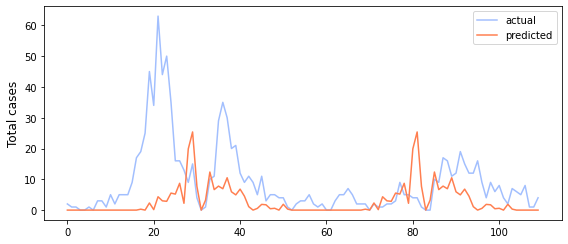

In [33]:
# Plot for saving with only the predictions from the HWES on non-transformed data
fig, ax = plt.subplots(figsize=(8,3.5))

# setup the figure with actual and predicted values
iq_train_test.reset_index().total_cases.plot(ax=ax, color=colors['actual_weekly'])
iq_pred_test.reset_index(drop=True).plot(ax=ax, color=colors['predicted_weekly']);
ax.legend(labels=['actual', 'predicted'], loc=0)
ax.set_ylabel('Total cases', fontsize=12)
ax.set_xlabel('')
ax.tick_params(labelsize=10)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('plots/IQ_holt_winters.png', dpi=200)